In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.decomposition import PCA

In [5]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna']

qna_mgmt = ['responsiveness', 'confidence', 'depth', 'evasiveness', 'language_accessibility_qna']
qna_analysts = ['analyst_concerns', 'analyst_satisfaction']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

In [6]:
def create_colored_chart(model, type):

    # Filter significant features
    significant_features = model.pvalues[model.pvalues < 0.05].index
    importances = model.params[significant_features]  # Only significant features
    importances = importances[1:]

    # Sort importances by their absolute value, and select the top 10
    top_12_importances = importances.abs().sort_values(ascending=False).head(10)
    importances = importances[top_12_importances.index]
    importances = importances.sort_values()  # Sort the values for better visualization

    # Define emotion types (assuming the feature names match these emotion labels)
    emotion_types = {
        'relief': 'positive',
        'remorse': 'negative',
        'nervousness': 'negative',
        'desire': 'positive',
        'fear': 'strong_negative',
        'excitement': 'positive',
        'confusion': 'negative',
        'pride': 'positive',
        'annoyance': 'negative',
        'gratitude': 'positive',
        'anger': 'strong_negative',
        'optimism': 'positive',
        'sadness': 'negative', 
        'approval': 'positive',
        'caring': 'positive',
        'disappointment': 'negative',
        'curiosity': 'positive',
        'surprise': 'positive',
        'admiration': 'positive',
        'embarrassment': 'negative',
        'realization': 'positive',
        'disapproval': 'negative',
        'joy': 'positive',
        'relief_analysts': 'positive',
        'remorse_analysts': 'negative',
        'nervousness_analysts': 'negative',
        'desire_analysts': 'positive',
        'fear_analysts': 'strong_negative',
        'excitement_analysts': 'positive',
        'confusion_analysts': 'negative',
        'pride_analysts': 'positive',
        'annoyance_analysts': 'negative',
        'gratitude_analysts': 'positive',
        'anger_analysts': 'strong_negative',
        'optimism_analysts': 'positive',
        'sadness_analysts': 'negative',
        'approval_analysts': 'positive',
        'caring_analysts': 'positive',
        'disappointment_analysts': 'negative',
        'curiosity_analysts': 'positive',
        'surprise_analysts': 'positive',
        'admiration_analysts': 'positive',
        'embarrassment_analysts': 'negative',
        'realization_analysts': 'positive',
        'disapproval_analysts': 'negative',
        'joy_analysts': 'positive'
    }

    # Map colors to each emotion type
    color_mapping = {
        'positive': 'green',
        'strong_negative': 'red',
        'negative': 'gray',
    }

    # Apply the color mapping to the top 12 significant features
    colors = []
    for feature in importances.index:
        if feature in supporting_features_1 or feature in supporting_features_2:
            colors.append('blue')
        elif feature in presentation_labels or feature in qna_labels:
            colors.append('orange')
        elif feature in emotion_types:
            colors.append(color_mapping[emotion_types[feature]])
        else:
            colors.append('purple')  # Default for unknown features

    # Create a horizontal bar plot for the top 12 significant features
    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')

    # Add labels and title
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Significant Features and their Impact')

    if type == 'Management Emotions' or type == 'Analyst Emotions' or type == 'All Emotions':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'All Earnings call':
        # Create a custom legend
        handles = [
            #plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                #'Financial Data', 
                'LLM Labels', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & Presentation Labels' or type == 'Financial Data & Q&A Labels' or type == 'Financial Data 1&2 & LLM Labels':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
        ]
        labels = [
                'Financial Data', 
                'LLM Labels', 
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & All Emotions' or type == 'Financial Data & Management Emotions' or type == 'Financial Data & Analyst Emotions':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Financial Data', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & All Earnings call':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Financial Data', 
                'LLM Labels', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'New Metrics':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='purple'),
        ]
        labels = [
                'Financial Data', 
                'New Metrics',
                ]
        # Add the legend
        plt.legend(handles, labels)

    # Show the plot
    return plt.show()


def create_significant_chart(model):

    # select significant features
    model.significance = model.pvalues[model.pvalues < 0.05].index

    # build a graph to show the importance of each feature
    importances = model.params[1:]
    importances = importances.sort_values()

    # Sort the importance values based on absolute values, not just positive or negative
    top_10_importances = importances.abs().sort_values(ascending=False).head(10)

    # reduce importances to only the top 10
    importances = importances[top_10_importances.index]
    importances = importances.sort_values()

    # color significant features 0/150/130 and others in grey
    colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')
    
    # add legend
    plt.legend(['Significant'])
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Features Impact on Recovery Rate')
    return plt.show()

In [7]:
# Function to compute the composite scores with flexible weights
def compute_scores(df, model, pca=False):

    # Function to normalize a subset of parameters
    def normalize_params(params, features):
        subset_params = np.abs(params[features])
        return subset_params / np.sum(subset_params)
    
    def finalize_weights(weights, features, params):
        # if features has negative values, set the weights to negative
        for feature in features:
            if params[feature] < 0:
                weights[feature] = -weights[feature]
        return weights

    def pca_weights(df, features, n_components=1):
        # Run PCA on the selected features
        pca = PCA(n_components=n_components)
        pca.fit(df[features])

        # Use the loadings (components) of the first principal component as weights
        # Absolute values are taken to avoid negative loadings but adjust as needed
        weights = np.abs(pca.components_[0])
        
        # Normalize weights to sum to 1
        weights = weights / weights.sum()
        return weights

    # Features used in each score
    mts_features = [
        'language_accessibility_presentation', 'language_accessibility_qna',
        'responsiveness', 'depth', 'evasiveness', 'uncertainty', 'vagueness',
        'approval', 'realization', 'curiosity', 'confusion', 'annoyance', 'nervousness',
        'admiration', 'relief', 'surprise'
        ]

    cami_features = [
        'debt_leverage_stress', 'confidence', 'optimistic', 'pessimistic',
        'recovery_strategies', 'legal_issues', 'macroeconomic',
        'industry_positioning', 'operational_trends', 'liquidity_position',
        'anger', 'fear', 'excitement', 'disappointment', 'disapproval',
        'pride', 'approval', 'remorse', 'confusion', 'sadness', 'optimism'
    ]
    aus_features = [
        'analyst_concerns', 'analyst_satisfaction',
        'disappointment_analysts', 'anger_analysts', 'fear_analysts',
        'nervousness_analysts', 'disapproval_analysts', 'joy_analysts',
        'approval_analysts', 'relief_analysts', 'excitement_analysts',
        'admiration_analysts', 'optimism_analysts', 'pride_analysts'
    ]

    if pca:
        mts_weights = pca_weights(df, mts_features)
        cami_weights = pca_weights(df, cami_features)
        aus_weights = pca_weights(df, aus_features)

    else:

        # Get the absolute values of the coefficients
        abs_params = np.abs(model.params)
    
        # Normalize the coefficients to sum to 1
        normalized_params = abs_params / np.sum(abs_params)

        # Normalize parameters for each score
        mts_weights = normalize_params(normalized_params, mts_features)
        cami_weights = normalize_params(normalized_params, cami_features)
        aus_weights = normalize_params(normalized_params, aus_features)

        # Finalize the weights
        mts_weights = finalize_weights(mts_weights, mts_features, model.params)
        cami_weights = finalize_weights(cami_weights, cami_features, model.params)
        aus_weights = finalize_weights(aus_weights, aus_features, model.params)

    # Management Transparency Score (MTS)
    df['MTS'] = np.dot(df[mts_features], mts_weights)

    # Crisis Awareness and Management Index (CAMI)
    df['CAMI'] = np.dot(df[cami_features], cami_weights)

    # Analysts Urgency Score (AUS)
    df['AUS'] = np.dot(df[aus_features], aus_weights)

    return df


In [9]:
model = sm.load('models/aggregated_all_features_model.pkl')
df = pd.read_csv('transcripts/LLM_outputs_final.csv')

In [10]:
with_PCA = True
if with_PCA:
    composite_df = compute_scores(df, model, pca=True)
else:
    composite_df = compute_scores(df, model, pca=False)

In [11]:
# Select the supporting features, nlp_lables, and RR from final_df
final_df = df[['RR']
                    + supporting_features_1
                    + supporting_features_2
                    + ['MTS', 'CAMI', 'AUS']
                    ]

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     81.38
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          1.66e-244
Time:                        17:37:48   Log-Likelihood:                -4386.8
No. Observations:                1075   AIC:                             8834.
Df Residuals:                    1045   BIC:                             8983.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

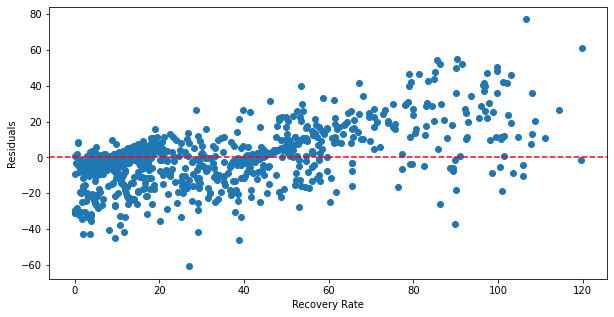

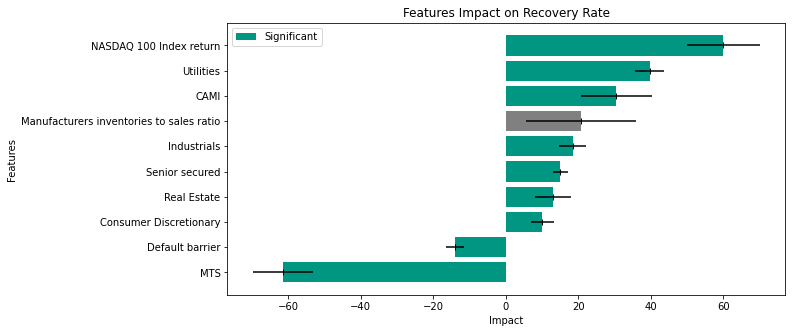

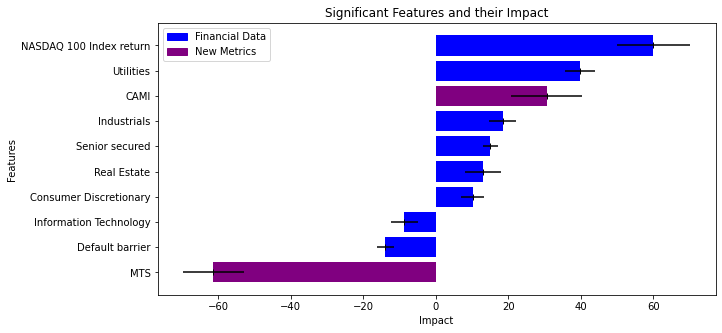

In [12]:
# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
#final_df = final_df.drop_duplicates()

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model, 'New Metrics')

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select relevant columns for PCA
pca_df = df[['RR'] 
                    + presentation_labels  
                    + qna_labels
                    + emotions
                    + analyst_emotions
                    ]

# Drop any rows with NaN values (or handle as required)
pca_df = pca_df.dropna()

# Separate features from the target variable 'RR'
X = pca_df.drop(columns=['RR'])
y = pca_df['RR']

# Standardize the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame to examine PCA components
pca_components_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(3)])

# Explained variance ratios for each principal component
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each principal component:", explained_variance)

# Display cumulative variance explained for interpretability
cumulative_variance = explained_variance.cumsum()
print("Cumulative explained variance:", cumulative_variance)


Explained variance by each principal component: [0.16428342 0.15136595 0.05417941]
Cumulative explained variance: [0.16428342 0.31564937 0.36982879]
